In [8]:
%run "Data Cleaning.ipynb"

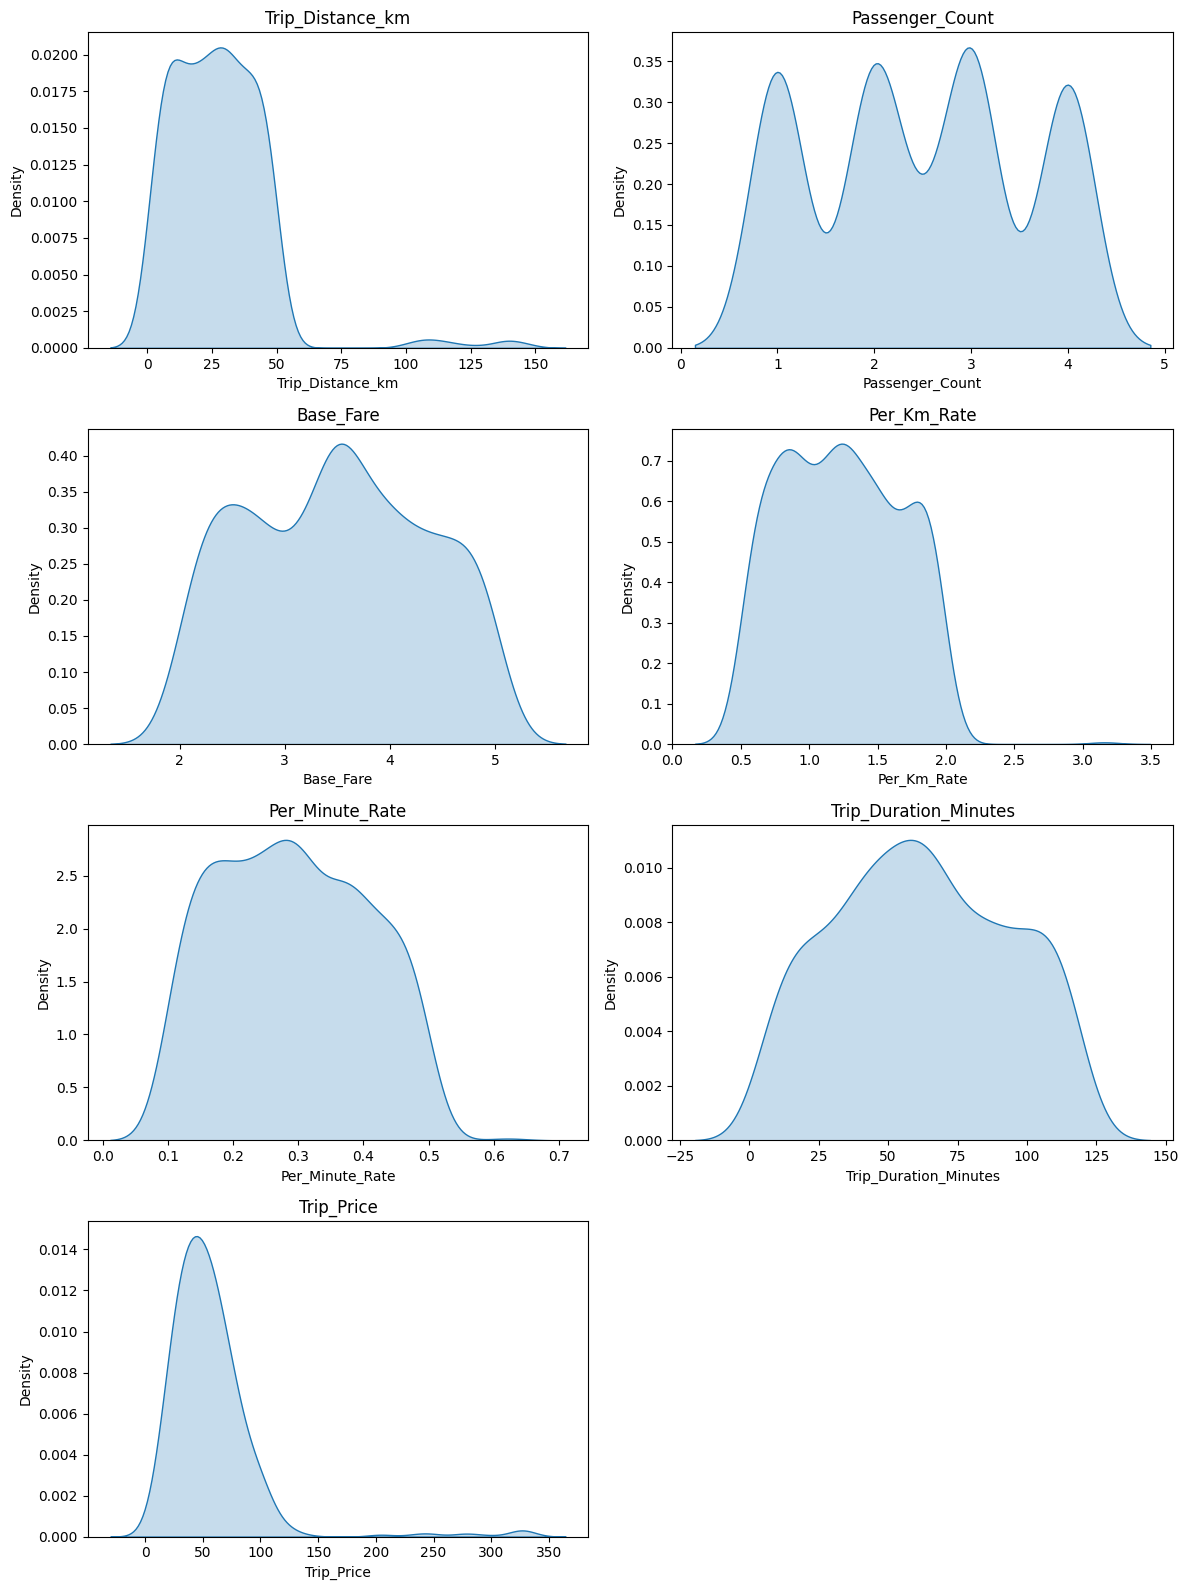

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols=num_df.columns
n_cols=2
n_rows=(len(num_cols) + n_cols - 1) // n_cols

fig,axes=plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
axes=axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(x=df[col], fill=True, ax=axes[i])
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


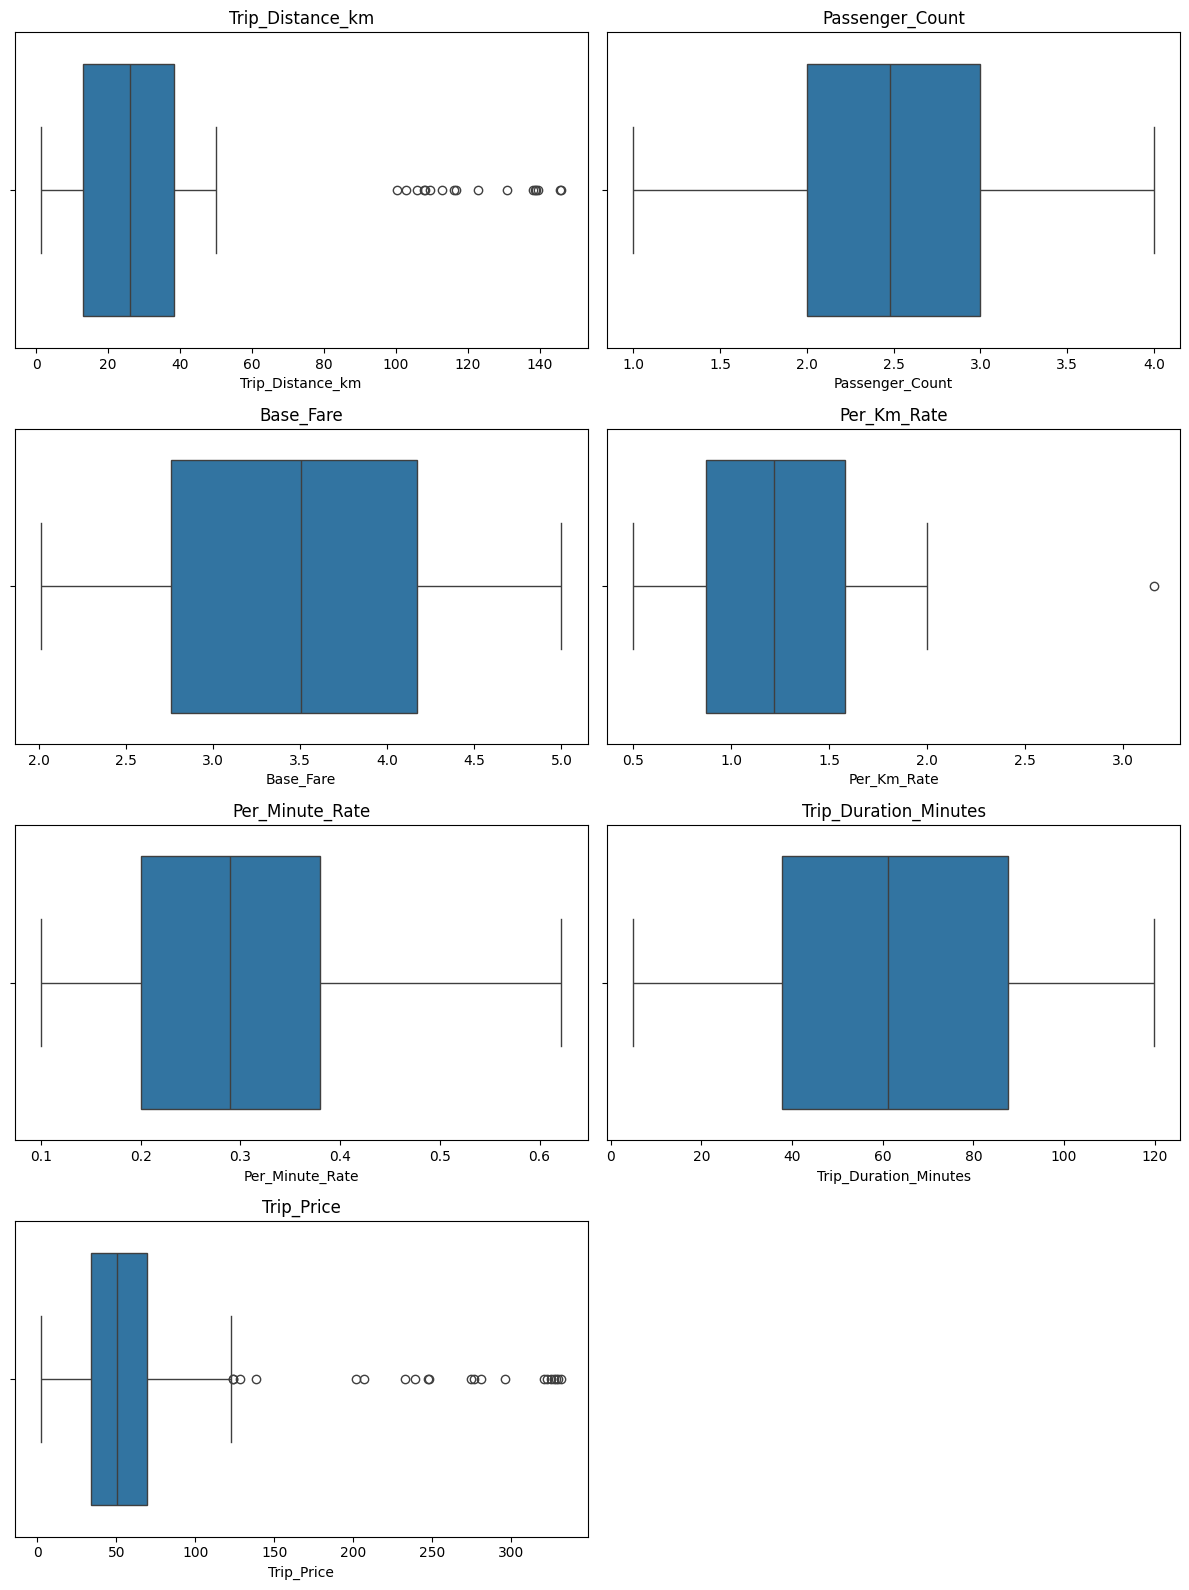

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols=num_df.columns
n_cols=2
n_rows=(len(num_cols) + n_cols - 1) // n_cols

fig,axes=plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
axes=axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], fill=True, ax=axes[i])
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

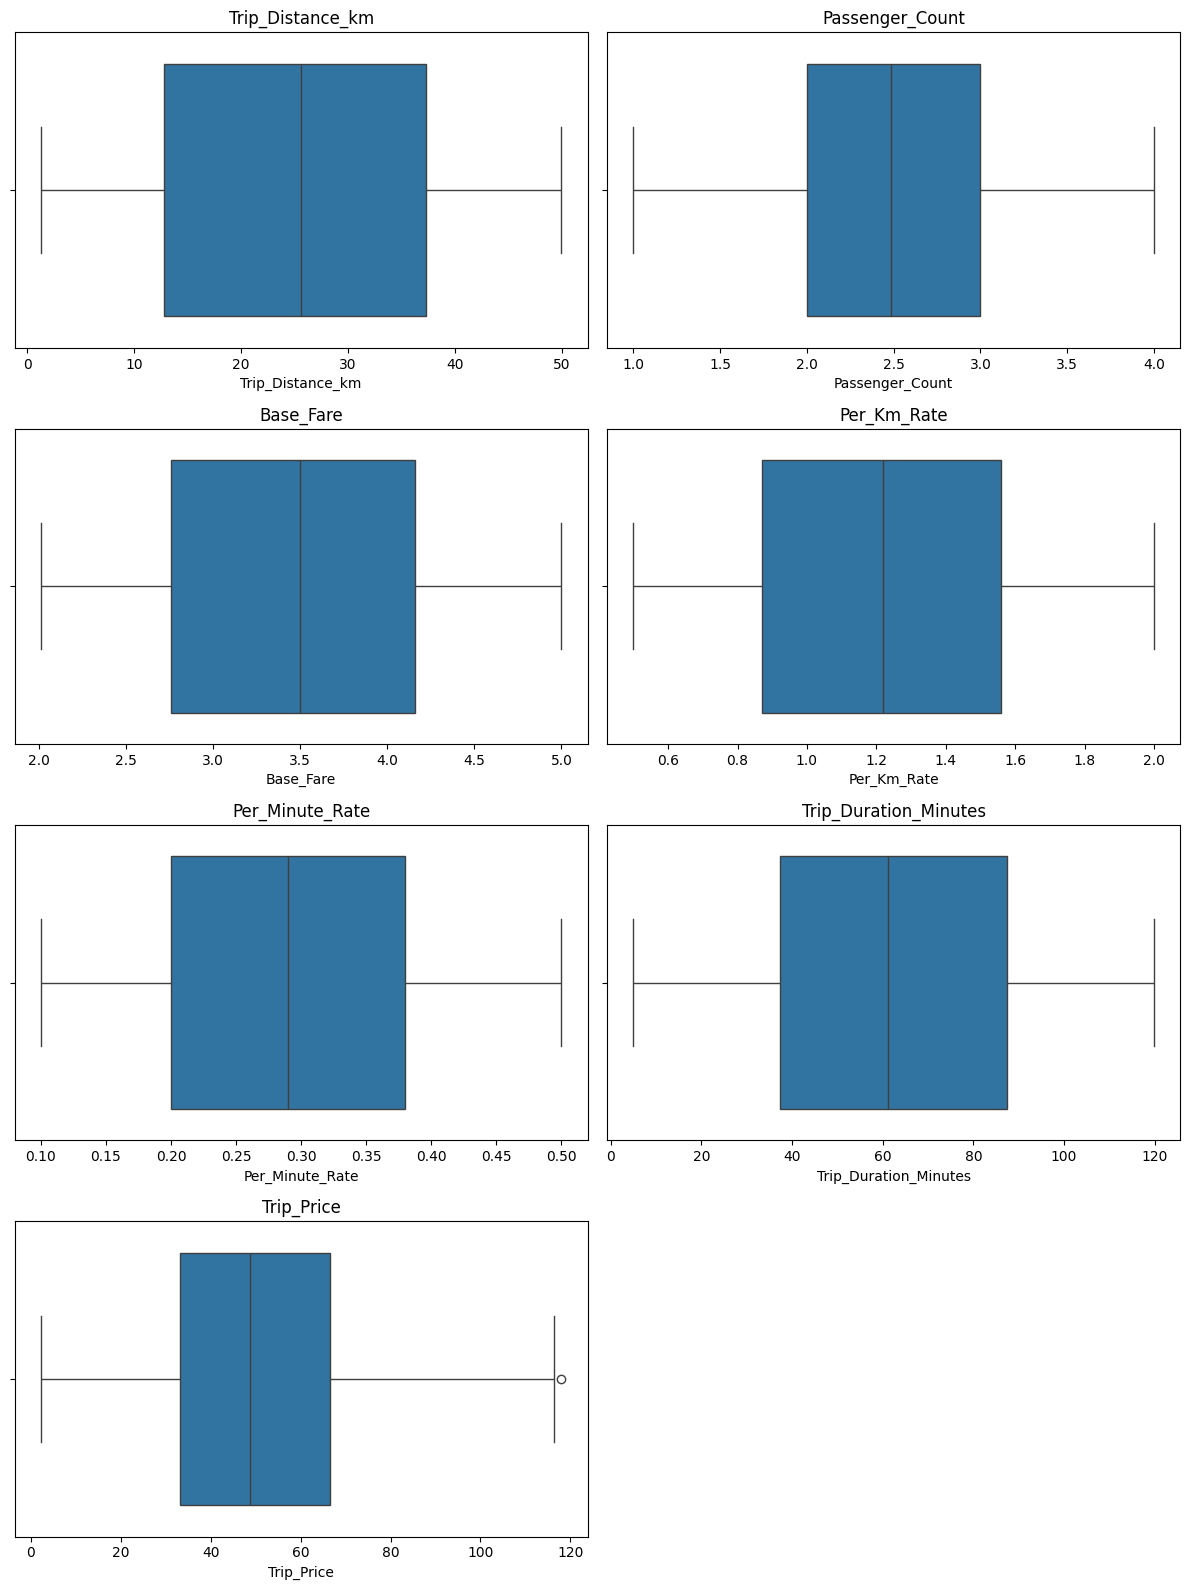

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols=num_df.columns
n_cols=2
n_rows=(len(num_cols) + n_cols - 1) // n_cols

fig,axes=plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
axes=axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], fill=True, ax=axes[i])
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
scaler=StandardScaler()
x=df.drop('Trip_Price',axis=1)
X_scaled = scaler.fit_transform(x)
X = pd.DataFrame(X_scaled,columns=x.columns)
y=df['Trip_Price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
model=LinearRegression()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print('Linar Regression:')
print(f'MSE:{mean_squared_error(y_test,y_pred)}')
print(f'R^2 Score:{r2_score(y_test,y_pred)}')

model1 = RandomForestRegressor(
    n_estimators=200,       
    max_depth=10,       
    min_samples_split=5,
    n_jobs=-1               
)
model1.fit(x_train, y_train)
y_pred1 = model1.predict(x_test)
print('RandomForestRegressor:')
print(f'MSE: {mean_squared_error(y_test, y_pred1)}')
print(f'R^2 Score: {r2_score(y_test, y_pred1)}\n')

model3 = DecisionTreeRegressor(
    max_depth=6,            
    min_samples_split=5,     
    min_samples_leaf=2,
    random_state=42
)
model3.fit(x_train, y_train)
y_pred3 = model3.predict(x_test)
print('DecisionTreeRegressor:')
print(f'MSE: {mean_squared_error(y_test, y_pred3)}')
print(f'R^2 Score: {r2_score(y_test, y_pred3)}')

Linar Regression:
MSE:0.07777166719208806
R^2 Score:0.9279664165447468
RandomForestRegressor:
MSE: 0.06971623433566393
R^2 Score: 0.9354275102293945

DecisionTreeRegressor:
MSE: 0.16257832346825765
R^2 Score: 0.8494168936530487


In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(model1,f)
column_names = x.columns.tolist()
with open('model_columns.pkl','wb') as f:
    pickle.dump(column_names,f)
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [31]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Install mlflow with: pip install mlflow
# Run mlflow server with: mlflow ui

# --- Step 1: Data Preparation ---
df = pd.read_csv('taxi_trip_pricing.csv')
df.dropna(inplace=True)

# Correctly mapping categorical string values to numerical values as per the HTML form
df['Time_of_Day'] = df['Time_of_Day'].replace({'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3})
df['Traffic_Conditions'] = df['Traffic_Conditions'].replace({'Low': 0, 'Medium': 1, 'High': 2})
df['Weather'] = df['Weather'].replace({'Clear': 0, 'Rain': 1, 'Snow': 2})
df['Day_of_Week'] = df['Day_of_Week'].replace({'Weekday': 0, 'Weekend': 1})

# Define features (X) and target (y)
features = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Time_of_Day', 'Traffic_Conditions', 'Weather', 'Day_of_Week']
X = df[features]
y = df['Trip_Price']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# --- Step 2: MLflow Model Training and Tracking ---
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("First Experiment")

with mlflow.start_run(run_name="Linear Regression"):
    model_lr = LinearRegression()
    model_lr.fit(x_train_scaled, y_train)
    y_pred_lr = model_lr.predict(x_test_scaled)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    mlflow.log_metric("MSE", mse_lr)
    mlflow.log_metric("R2", r2_lr)
    mlflow.sklearn.log_model(model_lr, "linear_regression_model")

rf_params = {"n_estimators": 200, "max_depth": 10, "min_samples_split": 5}
with mlflow.start_run(run_name="Random Forest Regressor"):
    model_rf = RandomForestRegressor(**rf_params, n_jobs=-1, random_state=42)
    model_rf.fit(x_train_scaled, y_train)
    y_pred_rf = model_rf.predict(x_test_scaled)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    mlflow.log_params(rf_params)
    mlflow.log_metric("MSE", mse_rf)
    mlflow.log_metric("R2", r2_rf)
    mlflow.sklearn.log_model(model_rf, "random_forest_model")

dt_params = {"max_depth": 6, "min_samples_split": 5, "min_samples_leaf": 2}
with mlflow.start_run(run_name="Decision Tree Regressor"):
    model_dt = DecisionTreeRegressor(**dt_params, random_state=42)
    model_dt.fit(x_train_scaled, y_train)
    y_pred_dt = model_dt.predict(x_test_scaled)
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    r2_dt = r2_score(y_test, y_pred_dt)
    mlflow.log_params(dt_params)
    mlflow.log_metric("MSE", mse_dt)
    mlflow.log_metric("R2", r2_dt)
    mlflow.sklearn.log_model(model_dt, "decision_tree_model")

C:\Users\kishore\AppData\Local\Temp\ipykernel_18592\1005909056.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Time_of_Day'] = df['Time_of_Day'].replace({'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3})
C:\Users\kishore\AppData\Local\Temp\ipykernel_18592\1005909056.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Traffic_Conditions'] = df['Traffic_Conditions'].replace({'Low': 0, 'Medium': 1, 'High': 2, 'Jam': 3})
C:\Users\kishore\AppData\Local\Temp\ipykernel_18592\1005909056.py:22: FutureWarning: Downcasti

MlflowException: API request to http://127.0.0.1:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=First+Experiment (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001A3B4908590>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))